# URL Query Binary Classifier [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/christopherwoodall/ml-for-cybersecurity/blob/main/query-binary-classifier/query-binary-classifier.ipynb)
## Machine Learning for Cybersecurity


In this notebook we will go over creating a very simple URL classifier. In order to classify a URL as `BENIGN` or `MALICIOUS` we will be using LR(Logistic Regression) as it requires a single input and returns `0` or `1`. Another application of this type of model includes spam filtering!

Check out the Github repo [here](https://github.com/christopherwoodall/ml-for-cybersecurity/tree/main/query-binary-classifier)

In [ ]:
%%bash
# Execute this cell if you are running in a remote jupyter environment; such as Google Colab or Kaggle Notebooks.

DATASET_DIR="./datasets"

if [ ! -d "${DATASET_DIR}" ]; then
  mkdir -p "${DATASET_DIR}"
  wget "https://github.com/christopherwoodall/ml-for-cybersecurity/blob/main/query-binary-classifier/datasets/benign_urls.json?raw=true" -O "${DATASET_DIR}/benign_urls.json"
  wget "https://github.com/christopherwoodall/ml-for-cybersecurity/blob/main/query-binary-classifier/datasets/malicious_urls.json?raw=true" -O "${DATASET_DIR}/malicious_urls.json"
  wget "https://github.com/christopherwoodall/ml-for-cybersecurity/blob/main/query-binary-classifier/datasets/url_classifier.pkl?raw=true" -O "${DATASET_DIR}/url_classifier.pkl"
  wget "https://github.com/christopherwoodall/ml-for-cybersecurity/blob/main/query-binary-classifier/datasets/grid_classifier.pkl?raw=true" -O "${DATASET_DIR}/grid_classifier.pkl"
  pip install matplotlib seaborn sklearn
fi

# Setup

In [20]:
import json
import urllib.parse

import numpy
import pandas
import seaborn

import matplotlib.pyplot as plt

from pathlib import Path


project_path   = Path.cwd()
datasets_path  = Path(project_path / "datasets")
benign_path    = Path(datasets_path / "benign_urls.json")
malicious_path = Path(datasets_path / "malicious_urls.json")

benign_data    = json.loads(benign_path.read_text(encoding="utf8"))
malicious_data = json.loads(malicious_path.read_text(encoding="utf8"))
all_data       = benign_data + malicious_data


print(f"Benign Examples:\t{len(benign_data)}")
print(f"Malicious Examples:\t{len(malicious_data)}")

Benign Examples:	1294531
Malicious Examples:	38190


# Splitting Data

Now we are going to split the data using `sklearn`'s `train_test_split()` function.


In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split


vectorizer = TfidfVectorizer(min_df=0.0, analyzer="char", sublinear_tf=True, ngram_range=(1,3))

x           = vectorizer.fit_transform(all_data)
y_malicious = [1] * len(benign_data)
y_benign    = [0] * len(malicious_data)
y           = y_malicious + y_benign

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=16)


# Classifier

Next let's create a Logistic Regression (aka logit, MaxEnt) classifier; check out the docs [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

In [22]:
from sklearn.linear_model import LogisticRegression


def new_model(x_train, y_train):
  model = LogisticRegression(
    class_weight = {1: 2 * len(benign_data) / len(malicious_data), 0: 1.0},
    max_iter     = 1000,
  )
  return train_model(model, x_train, y_train)
  

def load_model(filename="./datasets/url_classifier.pkl"):
  return __import__("pickle").load(open(filename, 'rb'))


def save_model(model, filename="./datasets/url_classifier.pkl"):
  __import__("pickle").dump(model, open(filename, 'wb'))
  return model


def train_model(model, x_train, y_train):
  return save_model(model.fit(x_train, y_train))


classifier = load_model() if Path("./datasets/url_classifier.pkl").exists() else new_model(x_train, y_train)


# Predictions

Now for the fun part. Below are a list of URLs and their categorization(benign or malicious).

In [25]:
test_data = [
  "facebook.com/post",                                # BENIGN
  "example/test.php",                                 # BENIGN
  "?google/images",                                   # BENIGN
  "contact.php=foo/bar",                              # BENIGN
  "comment.php=foooooooooooooooobarbaaz",             # BENIGN
  "contact.php=\"';/><script>alert(1)</script>",      # MALICIOUS
  "login.php=SELECT password from admin",             # MALICIOUS
  "\"><svg onload=confirm(1)>",                       # MALICIOUS
  "q=../etc/passwd",                                  # MALICIOUS
  "contact/javascript:confirm(1)",                    # MALICIOUS
  "email.aspx=\"><svg onclick=alert(1)",              # MALICIOUS
  "<img src=xx onerror=confirm(1)>",                  # MALICIOUS
  "example/test/q=<script>alert(1)</script>",         # MALICIOUS
  "example/test/q=<svg onload=confirm('faizan')>",    # MALICIOUS
  "fsecurify/q=<svg onerror=confirm('fsecurify')>",   # MALICIOUS
  "example/test/q=<a href=\"javascript:confirm(1)>",  # MALICIOUS
]
__import__("random").shuffle(test_data)

for url in test_data:
  prediction = 'BENIGN' if classifier.predict(vectorizer.transform([url])) else 'MALICIOUS'
  print(f"{prediction} | {url}")


MALICIOUS | email.aspx="><svg onclick=alert(1)
MALICIOUS | "><svg onload=confirm(1)>
MALICIOUS | example/test/q=<svg onload=confirm('faizan')>
BENIGN | login.php=SELECT password from admin
MALICIOUS | example/test/q=<script>alert(1)</script>
MALICIOUS | <img src=xx onerror=confirm(1)>
BENIGN | facebook.com/post
BENIGN | comment.php=foooooooooooooooobarbaaz
BENIGN | example/test.php
BENIGN | contact.php=foo/bar
MALICIOUS | q=../etc/passwd
BENIGN | ?google/images
MALICIOUS | example/test/q=<a href="javascript:confirm(1)>
MALICIOUS | contact.php="';/><script>alert(1)</script>
MALICIOUS | fsecurify/q=<svg onerror=confirm('fsecurify')>
BENIGN | contact/javascript:confirm(1)


# Confusion Matrix

This is a table used to visualize model *correctness*.

Accuracy: 0.9986223704232834
Classification report:
              precision    recall  f1-score   support

   MALICIOUS       1.00      0.95      0.98      9450
      BENIGN       1.00      1.00      1.00    323731

    accuracy                           1.00    333181
   macro avg       1.00      0.98      0.99    333181
weighted avg       1.00      1.00      1.00    333181

Prediction probabilities:
[[1.83602212e-05 9.99981640e-01]
 [5.64511855e-06 9.99994355e-01]
 [2.98669203e-05 9.99970133e-01]
 ...
 [6.84371076e-05 9.99931563e-01]
 [1.16911297e-06 9.99998831e-01]
 [2.03992142e-06 9.99997960e-01]]


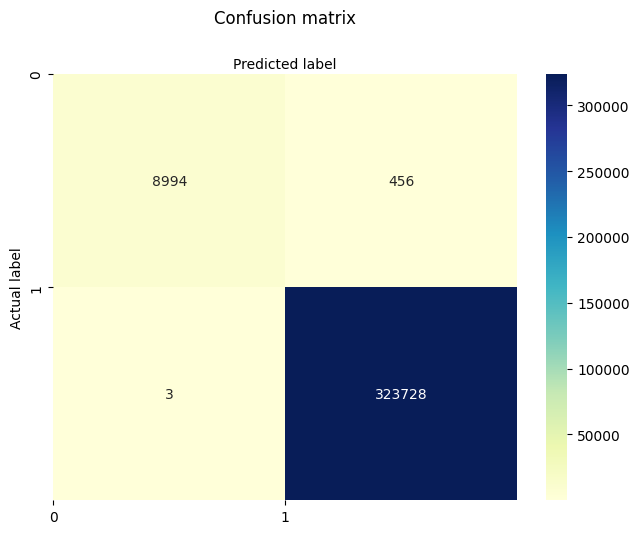

In [27]:
from sklearn.metrics import classification_report, confusion_matrix


class_names  = [0, 1]
target_names = ['MALICIOUS', 'BENIGN']

y_pred = classifier.predict(x_test)

cnf_matrix = confusion_matrix(y_test, y_pred)
tick_marks = numpy.arange(len(class_names))
fig, ax    = plt.subplots()

seaborn.heatmap(pandas.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

print(f"Accuracy: {classifier.score(x_test, y_test)}")
print("Classification report:")
print(classification_report(y_test, y_pred, target_names=target_names))
print("Prediction probabilities:")
print(classifier.predict_proba(x_test))

plt.show()


# Improving the Model with Grid Search

Check out the ROC(Receiver Operating Characteristic) Curve graphs below.

In [34]:
from sklearn.model_selection import GridSearchCV


grid_model_path = Path("./datasets/grid_classifier.pkl")
grid_params = {
  "max_iter":     [300, 600, 1000],
  "solver":       ["newton-cg", "lbfgs", "liblinear", 'sag', 'saga'],
  "class_weight": [{1: 2 * len(benign_data) / len(malicious_data), 0: 1.0},]
}


if grid_model_path.exists():
  grid = __import__("pickle").load(open(grid_model_path, 'rb'))
else:
  grid = GridSearchCV(estimator=LogisticRegression(random_state=42), param_grid=grid_params, verbose=1, cv=3, n_jobs=-1)
  grid.fit(x_train, y_train)
  __import__("pickle").dump(grid, open(grid_model_path, 'wb'))


Fitting 2 folds for each of 6 candidates, totalling 12 fits


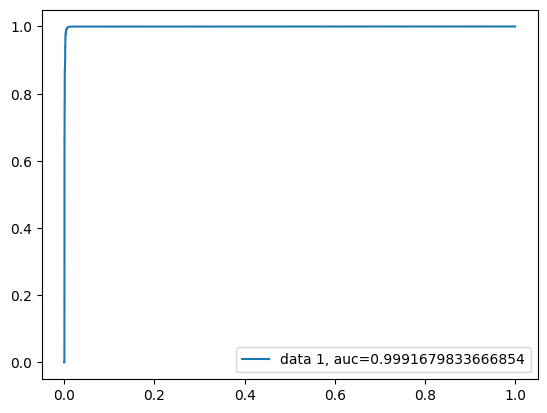

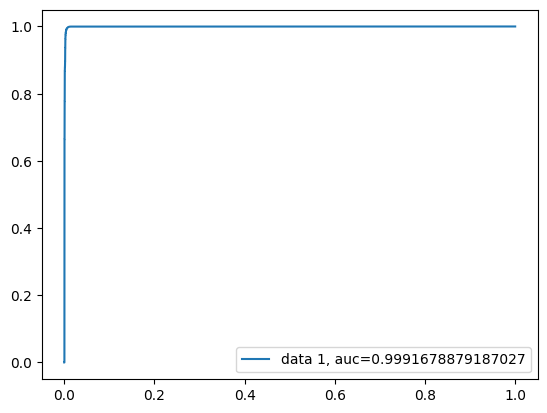

In [35]:
import sklearn


def show_roc_curve(classifier, x_test, y_test):
  y_pred_proba = classifier.predict_proba(x_test)[::,1]
  fpr, tpr, _ = sklearn.metrics.roc_curve(y_test, y_pred_proba)
  auc = sklearn.metrics.roc_auc_score(y_test, y_pred_proba)
  plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
  plt.legend(loc=4)
  plt.show()


show_roc_curve(grid, x_test, y_test)
show_roc_curve(classifier, x_test, y_test)


## Datasets

- [HTTP DATASET CSIC 2010](https://www.isi.csic.es/dataset/)[src](https://www.kaggle.com/datasets/ispangler/csic-2010-web-application-attacks) - Developed at the Information Security Institute of CSIC(Spanish Research National Council), the dataset ccontains thousands of automatically generated web request.
- [MACCDC2012](http://www.secrepo.com/) - Dataset containing everything from scanning/recon through explotation as well as some c99 shell traffic. Roughly 22694356 total connections.
- [fuzzdb](https://github.com/fuzzdb-project/fuzzdb) - The first and most comprehensive open dictionary of fault injection patterns, predictable resource locations, and regex for matching server responses.


## Resources
- [Binary Classification with Logistic Regression](https://python.plainenglish.io/binary-classification-with-logistic-regression-12a623ca759b)
- [Spam filter github project.ipynb ](https://gist.github.com/Matheesan2113/95afe46cff7ce49a2602e9ec0af4db5a)

## Acknowledgements

This project is a resurrection of Faizan Ahmad's [fWaf](http://web.archive.org/web/20170706222016/http://fsecurify.com/fwaf-machine-learning-driven-web-application-firewall/), please go check out the Github repo [here](https://github.com/faizann24/Fwaf-Machine-Learning-driven-Web-Application-Firewall)!
